In [1]:
# importing tool functions
import numpy as np
import matplotlib.pyplot as plt
from tools import utils, ml_tools
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

DIRECTORY AND READ IN PRE-PROCESSED DOCUMENTS

In [2]:
dir_name_e = r'C:\Users\EfiaA\OneDrive - Imperial College London\Imperial academic work\University life\Y4\MSci project\Project_Coding\nlp-physicseducation\Pickledfiles'

In [3]:
# import the yr1c1c1 labels
dir_csv = 'outputs/labels_cleaned_y1c1c2.csv'
df = pd.read_csv(dir_csv, encoding='utf-8')

CODE REFERENCE 

In [4]:
# code reference
#https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

LATENT DIRCHLET ALOCATION - TOPIC MODELLING

In [5]:
# prepare for LDA analysis
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EfiaA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1.1 Removing stop words

In [6]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df['Content'].tolist()
data_words_send = list(sent_to_words(data))


# remove stop words
data_words_nostopwords = remove_stopwords(data_words_send)
print(data_words_nostopwords[:1][0][:30])

['atom', 'atomic', 'number', 'vacuum', 'permittivity', 'electron', 'mass', 'charge', 'electron', 'divide', 'eq', 'eq', 'potential', 'kinetic', 'energy', 'electron', 'respectively', 'since', 'energy', 'photon', 'emit', 'hydrogen', 'atom', 'give', 'difference', 'two', 'hydrogen', 'energy', 'level', 'positive']


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostopwords, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_nostopwords], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
!python -m spacy download en_core_web_sm
import spacy

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostopwords)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
['atom', 'number', 'vacuum', 'potential', 'respectively', 'energy', 'emit', 'atom', 'give', 'difference', 'hydrogen', 'energy', 'level', 'positive', 'integer', 'great', 'relationship', 'wavelength', 'speed', 'rewrite', 'hydrogen', 'atom', 'atomic', 'number', 'therefore', 'rydberg', 'constant', 'define', 'experiment', 'experimentally']


1.2 Corpus and Term Document frequency

In [10]:
#create 

id2word = corpora.Dictionary(data_lemmatized)

#create corpus
texts = data_lemmatized

#Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

#View 
print(len(corpus))

95


1.3 Train LDA - no feature extraction

In [11]:
#LDA model training 
from pprint import pprint
from gensim.models import CoherenceModel
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       passes= 10)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
print(doc_lda)

[(0,
  '0.001*"value" + 0.001*"error" + 0.001*"wavelength" + 0.001*"grate" + '
  '0.001*"line" + 0.001*"constant" + 0.001*"light" + 0.001*"order" + '
  '0.001*"energy" + 0.001*"experiment"'),
 (1,
  '0.001*"value" + 0.001*"wavelength" + 0.001*"error" + 0.001*"line" + '
  '0.001*"grate" + 0.001*"light" + 0.001*"constant" + 0.001*"order" + '
  '0.001*"energy" + 0.001*"experiment"'),
 (2,
  '0.022*"line" + 0.015*"wavelength" + 0.014*"value" + 0.014*"order" + '
  '0.014*"energy" + 0.014*"see" + 0.013*"figure" + 0.012*"emission" + '
  '0.011*"grate" + 0.010*"difference"'),
 (3,
  '0.035*"error" + 0.029*"value" + 0.011*"energy" + 0.011*"experiment" + '
  '0.011*"would" + 0.011*"wavelength" + 0.010*"calculate" + 0.010*"give" + '
  '0.009*"constant" + 0.009*"accept"'),
 (4,
  '0.024*"line" + 0.024*"value" + 0.024*"constant" + 0.023*"wavelength" + '
  '0.020*"light" + 0.018*"error" + 0.017*"grate" + 0.015*"energy" + '
  '0.012*"diffraction" + 0.012*"order"'),
 (5,
  '0.020*"wavelength" + 0.019*

In [9]:
# Compute Coherence Score
# coherence model requires the original text to be fed in, instead of the pre-processed text
coherence_model_lda = CoherenceModel(model=lda_model, texts= data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda, 'iteration no:', 5)
print(coherence_lda)

Coherence Score:  0.29652629632821986 iteration no: 5
0.29652629632821986


ITERATIONS for LDA
coherence analysis 
towards data science:
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [11]:
from pprint import pprint
from gensim.models import CoherenceModel

coherence_arr = []
# number of topics
num_topics = 10

# iteration number; max =10
iter_no = 10
for i in range(iter_no):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       passes= i)
    # Print the Keyword in the 10 topics
    #pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
 
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts= data_words, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda, 'iteration no:', i)
    coherence_arr.append(coherence_lda)

    

Coherence Score:  0.7232195979280645 iteration no: 0
Coherence Score:  0.2948510113473099 iteration no: 1
Coherence Score:  0.31197105929394814 iteration no: 2
Coherence Score:  0.2912890954084613 iteration no: 3
Coherence Score:  0.2942590860822495 iteration no: 4
Coherence Score:  0.30276233524733914 iteration no: 5
Coherence Score:  0.29014306522434996 iteration no: 6
Coherence Score:  0.2979291353210156 iteration no: 7
Coherence Score:  0.30392244561109644 iteration no: 8
Coherence Score:  0.2996543873818053 iteration no: 9


Text(0, 0.5, 'Coherence')

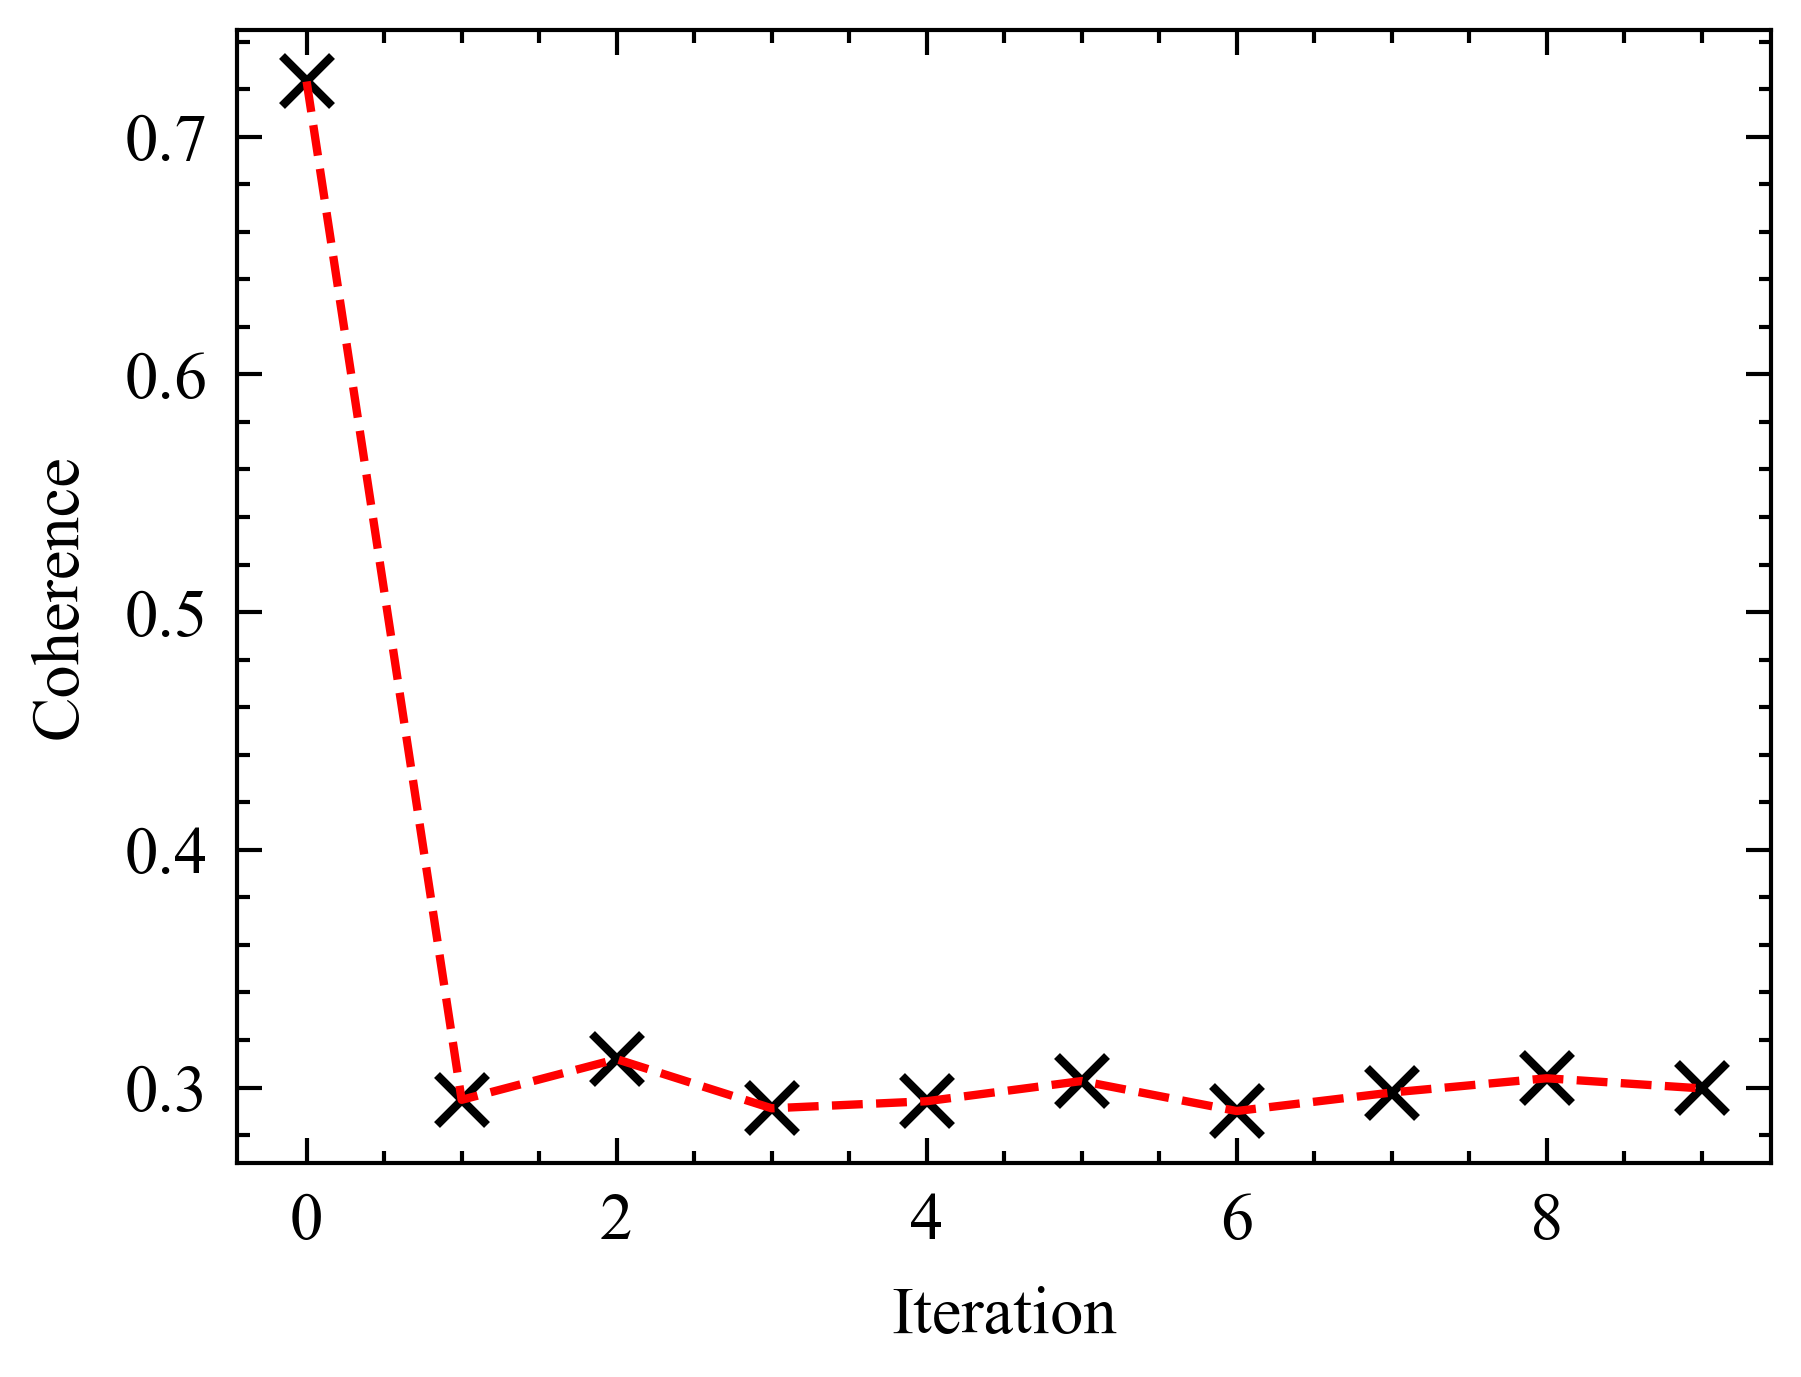

In [20]:
# imports for scienceplots
import matplotlib
import scienceplots
plt.style.use(['science', 'ieee','no-latex'])
matplotlib.rc('font', family='times new roman')

plt.plot(arr, coherence_arr, 'x')
plt.plot(arr, coherence_arr, '--')
plt.xlabel('Iteration')
plt.ylabel('Coherence')

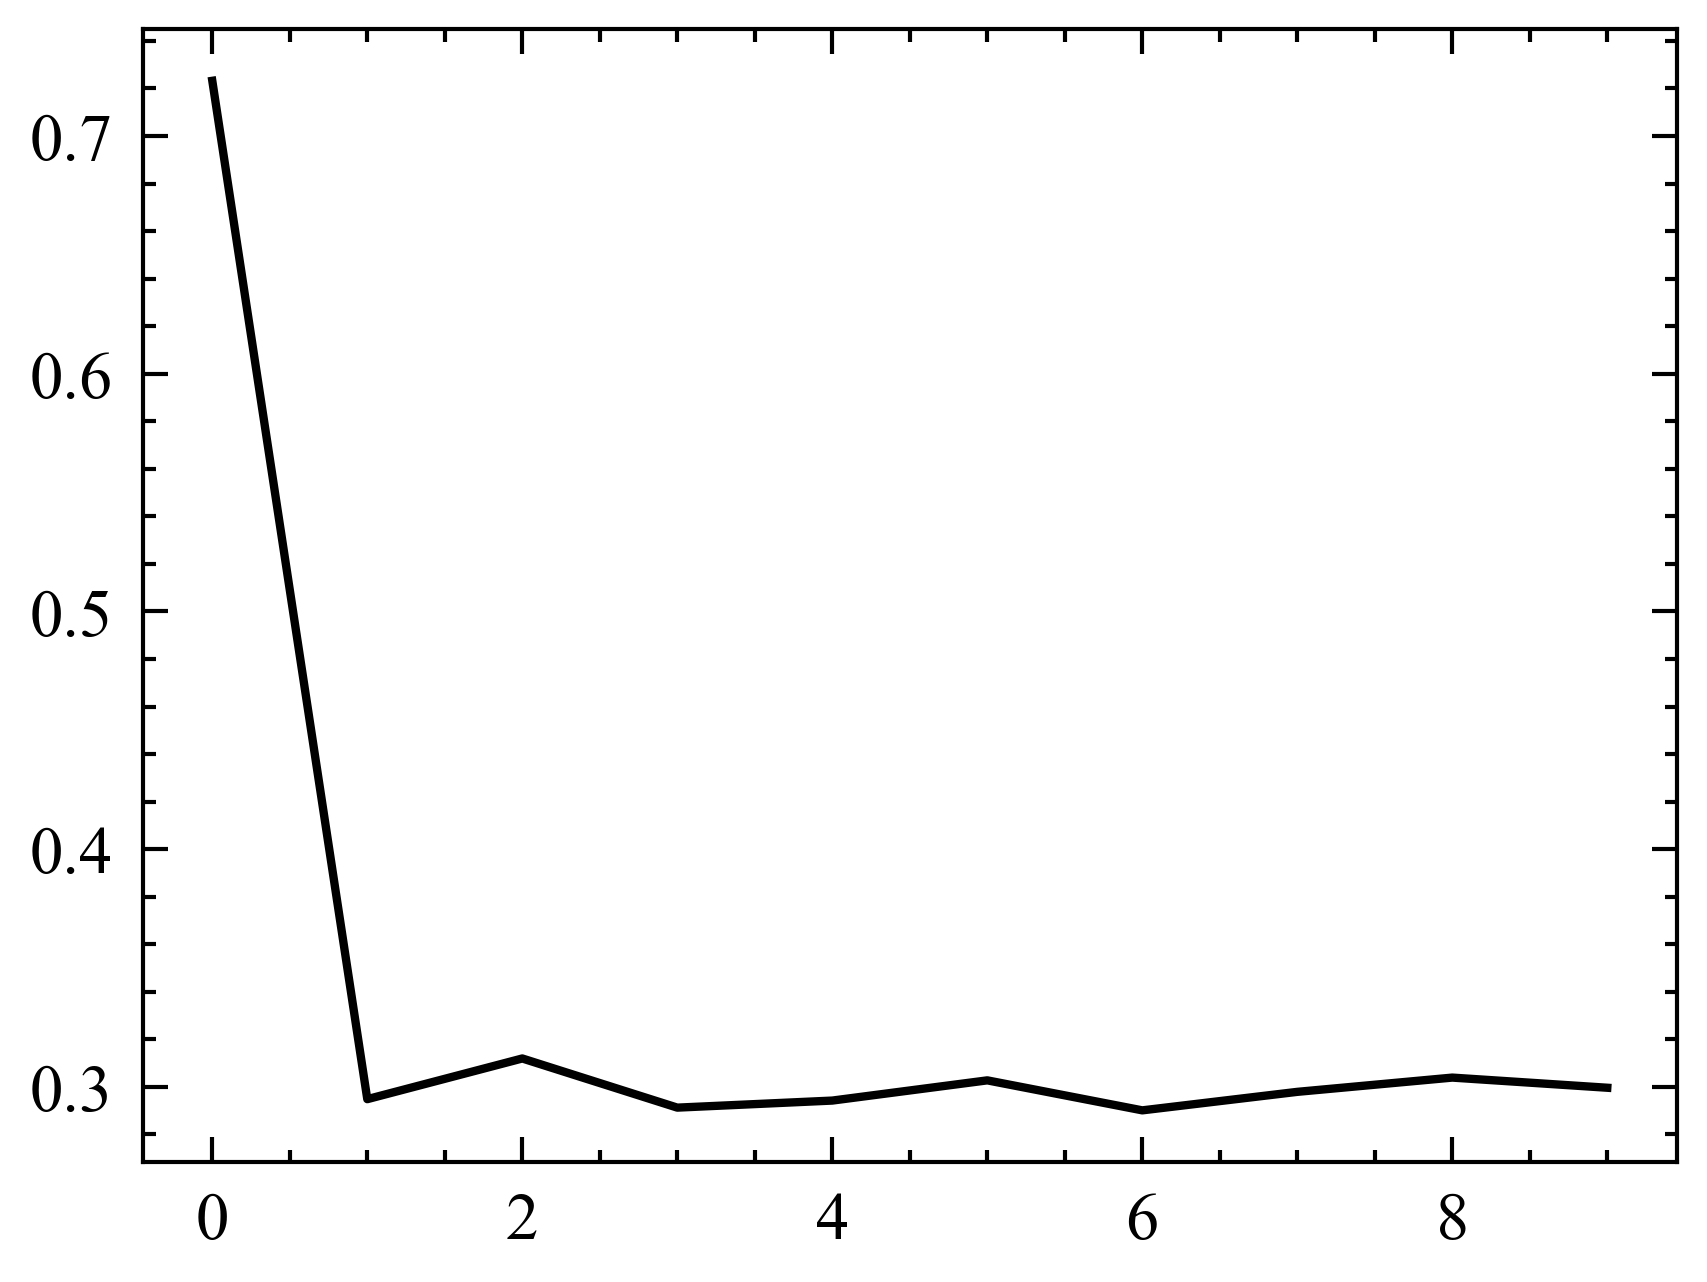

In [29]:
import matplotlib
import scienceplots
plt.style.use(['science', 'ieee','no-latex'])
matplotlib.rc('font', family='times new roman')

plt.plot(coherence_arr)

1.4 Display LDA topics - no feature extraction

In [12]:
%pip install pyLDAvis==2.1.2
import pickle 
import pyLDAvis
from pyLDAvis import gensim
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(dir_name_e+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, dir_name_e + str(num_topics) +'.html')
LDAvis_prepared

Note: you may need to restart the kernel to use updated packages.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.111306 -0.004873       1        1  73.972545
6      0.115355  0.013996       2        1  10.418398
9      0.087279 -0.010167       3        1   4.486711
3      0.055776 -0.034122       4        1   3.151553
2      0.027013  0.093970       5        1   2.557490
5      0.044756  0.068773       6        1   2.479355
7      0.046703 -0.098818       7        1   2.186118
8     -0.054163 -0.033903       8        1   0.720154
0     -0.214523  0.001970       9        1   0.013838
1     -0.219502  0.003174      10        1   0.013838, topic_info=            Term         Freq        Total Category  logprob  loglift
132        value  1618.000000  1618.000000  Default  30.0000  30.0000
39         error  1295.000000  1295.000000  Default  29.0000  29.0000
20      constant  1373.000000  1373.000000  Default  28.0000  28.0000
70          line  1594.000000  1594.000000  Default  27.0000  27.0000
69         light  1205.000000  1205.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
68         level     0.004337   547.506456  Topic10  -7.6904  -2.8605
30   diffraction     0.004373   708.338361  Topic10  -7.6820  -3.1097
50          give     0.004252   434.077529  Topic10  -7.7103  -2.6482
108          see     0.004153   365.238991  Topic10  -7.7337  -2.4989
489    telescope     0.004169   429.379493  Topic10  -7.7299  -2.6570

[792 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2498      6  0.680197   abandon
138       1  0.772136      able
138       2  0.078968      able
138       3  0.008774      able
138       4  0.070194      able
...     ...       ...       ...
615       8  0.077522     write
2432      8  0.813610        δe
2591      3  0.645901  𝑐𝑜𝑛𝑠𝑡𝑎𝑛𝑡
333       1  0.291416      𝑑𝑠𝑖𝑛
333       3  0.582832      𝑑𝑠𝑖𝑛

[1413 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 10, 4, 3, 6, 8, 9, 1, 2])

2.1 BAG OF WORDS -LDA

In [10]:
# bag of words
count = 0
for k,v in id2word.iteritems():
    print(k,v)
    count +=1
    if count > 10:
        break

0 add
1 affected
2 air
3 align
4 also
5 although
6 analysis
7 angle
8 angular
9 atom
10 atomic


c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.1 Feature extraction method - BAG OF WORDS

In [32]:
id2word.filter_extremes(no_below=12,no_above=0.5, keep_n = 100000)

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
bow_corpus = [id2word.doc2bow(doc) for doc in data_lemmatized]

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
bow_doc_95 = bow_corpus[94]
for i in range(len(bow_doc_95)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_95[i][0], 
                                               id2word[bow_doc_95[i][0]], 
bow_doc_95[i][1]))

Word 0 ("add") appears 1 time.
Word 1 ("affect") appears 1 time.
Word 4 ("atomic") appears 1 time.
Word 5 ("background") appears 3 time.
Word 7 ("camera") appears 1 time.
Word 9 ("clear") appears 3 time.
Word 10 ("dark") appears 1 time.
Word 14 ("directly") appears 1 time.
Word 16 ("ensure") appears 3 time.
Word 19 ("factor") appears 2 time.
Word 20 ("fall") appears 1 time.
Word 21 ("form") appears 4 time.
Word 23 ("gas") appears 4 time.
Word 24 ("great") appears 1 time.
Word 28 ("improve") appears 1 time.
Word 32 ("negligible") appears 1 time.
Word 33 ("orbital") appears 1 time.
Word 34 ("parallel") appears 1 time.
Word 41 ("relationship") appears 2 time.
Word 43 ("room") appears 2 time.
Word 44 ("size") appears 3 time.
Word 45 ("still") appears 3 time.
Word 52 ("various") appears 6 time.
Word 54 ("able") appears 1 time.
Word 58 ("aim") appears 1 time.
Word 61 ("appear") appears 1 time.
Word 63 ("attempt") appears 2 time.
Word 65 ("bar") appears 1 time.
Word 69 ("central") appears 1 t

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.2 Feature extraction method - TFIDF

In [35]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.1887099822577297),
 (1, 0.21217024327697498),
 (2, 0.0687232537267432),
 (3, 0.10971489589763235),
 (4, 0.12476551535720085),
 (5, 0.06677505117413676),
 (6, 0.09435499112886485),
 (7, 0.06677505117413676),
 (8, 0.07930437166929633),
 (9, 0.07930437166929633),
 (10, 0.16798699459979796),
 (11, 0.10971489589763235),
 (12, 0.07277838081294344),
 (13, 0.14361449485589578),
 (14, 0.10318890504127946),
 (15, 0.07277838081294344),
 (16, 0.054393808873567547),
 (17, 0.09435499112886485),
 (18, 0.12476551535720085),
 (19, 0.09162736031163837),
 (20, 0.0687232537267432),
 (21, 0.059452011571185216),
 (22, 0.25935835757638104),
 (23, 0.14144682885131662),
 (24, 0.059452011571185216),
 (25, 0.11686331008712972),
 (26, 0.13843992040305111),
 (27, 0.12476551535720085),
 (28, 0.12243367216660468),
 (29, 0.059452011571185216),
 (30, 0.2983454198934604),
 (31, 0.11890402314237043),
 (32, 0.07930437166929633),
 (33, 0.27687984080610223),
 (34, 0.10878761774713509),
 (35, 0.09435499112886485),
 (

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
%pip install pyLDAvis==2.1.2
import pickle 
import pyLDAvis
from pyLDAvis import gensim
from gensim.models.ldamulticore import LdaMulticore

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note: you may need to restart the kernel to use updated packages.


2.3 Train LDA model - bow

In [16]:
lda_model = LdaMulticore(bow_corpus, num_topics=10, id2word=id2word, passes=2, workers=2)

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
topic_arr = []
index = []
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    topic_arr.append(topic)
    index.append(idx)

Topic: 0 
Words: 0.014*"crosshair" + 0.010*"accuracy" + 0.009*"since" + 0.009*"able" + 0.008*"pattern" + 0.008*"gas" + 0.008*"random" + 0.007*"linear" + 0.007*"thus" + 0.007*"ensure"
Topic: 1 
Words: 0.013*"able" + 0.013*"violet" + 0.011*"setup" + 0.008*"aqua" + 0.008*"carry" + 0.008*"collect" + 0.007*"accuracy" + 0.007*"much" + 0.007*"may" + 0.006*"since"
Topic: 2 
Words: 0.009*"random" + 0.009*"fringe" + 0.008*"thus" + 0.008*"quantum" + 0.008*"wave" + 0.008*"since" + 0.008*"may" + 0.008*"define" + 0.007*"able" + 0.007*"background"
Topic: 3 
Words: 0.014*"thus" + 0.010*"pattern" + 0.009*"discrete" + 0.008*"violet" + 0.008*"model" + 0.008*"hence" + 0.007*"centre" + 0.007*"interference" + 0.007*"nucleus" + 0.006*"percentage"
Topic: 4 
Words: 0.016*"violet" + 0.011*"since" + 0.011*"green" + 0.009*"associate" + 0.008*"hence" + 0.007*"crosshair" + 0.007*"get" + 0.007*"aqua" + 0.007*"fit" + 0.007*"linear"
Topic: 5 
Words: 0.012*"air" + 0.010*"random" + 0.009*"theoretical" + 0.009*"orbit" + 

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
#print(lda_model.print_topics(-1))
lda_model_bow = LdaMulticore(bow_corpus, num_topics=10, id2word= id2word, passes=2, workers=4)
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic: 0 Word: 0.008*"thus" + 0.008*"pattern" + 0.007*"nucleus" + 0.007*"orbit" + 0.007*"may" + 0.007*"crosshair" + 0.006*"element" + 0.006*"appear" + 0.006*"model" + 0.006*"minute"
Topic: 1 Word: 0.020*"since" + 0.012*"associate" + 0.010*"wire" + 0.009*"random" + 0.009*"thus" + 0.009*"expect" + 0.008*"get" + 0.007*"green" + 0.007*"accuracy" + 0.006*"fit"
Topic: 2 Word: 0.009*"much" + 0.007*"centre" + 0.007*"since" + 0.006*"meaning" + 0.006*"crosshair" + 0.006*"plane" + 0.006*"may" + 0.006*"pattern" + 0.006*"exactly" + 0.006*"gas"
Topic: 3 Word: 0.014*"hence" + 0.010*"setup" + 0.009*"purple" + 0.009*"thus" + 0.009*"fit" + 0.008*"certain" + 0.008*"percentage" + 0.008*"centre" + 0.007*"note" + 0.007*"able"
Topic: 4 Word: 0.051*"fringe" + 0.011*"experimental" + 0.009*"quantum" + 0.008*"model" + 0.008*"theoretical" + 0.007*"orbit" + 0.007*"angular" + 0.007*"great" + 0.007*"associate" + 0.006*"centre"
Topic: 5 Word: 0.014*"purple" + 0.012*"fringe" + 0.011*"random" + 0.009*"quantum" + 0.008*

2.4 Word map showing topic groupings - BOW

In [ ]:
import matplotlib
import scienceplots
plt.style.use(['science', 'ieee','no-latex'])
matplotlib.rc('font', family='times new roman')

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: list index out of range

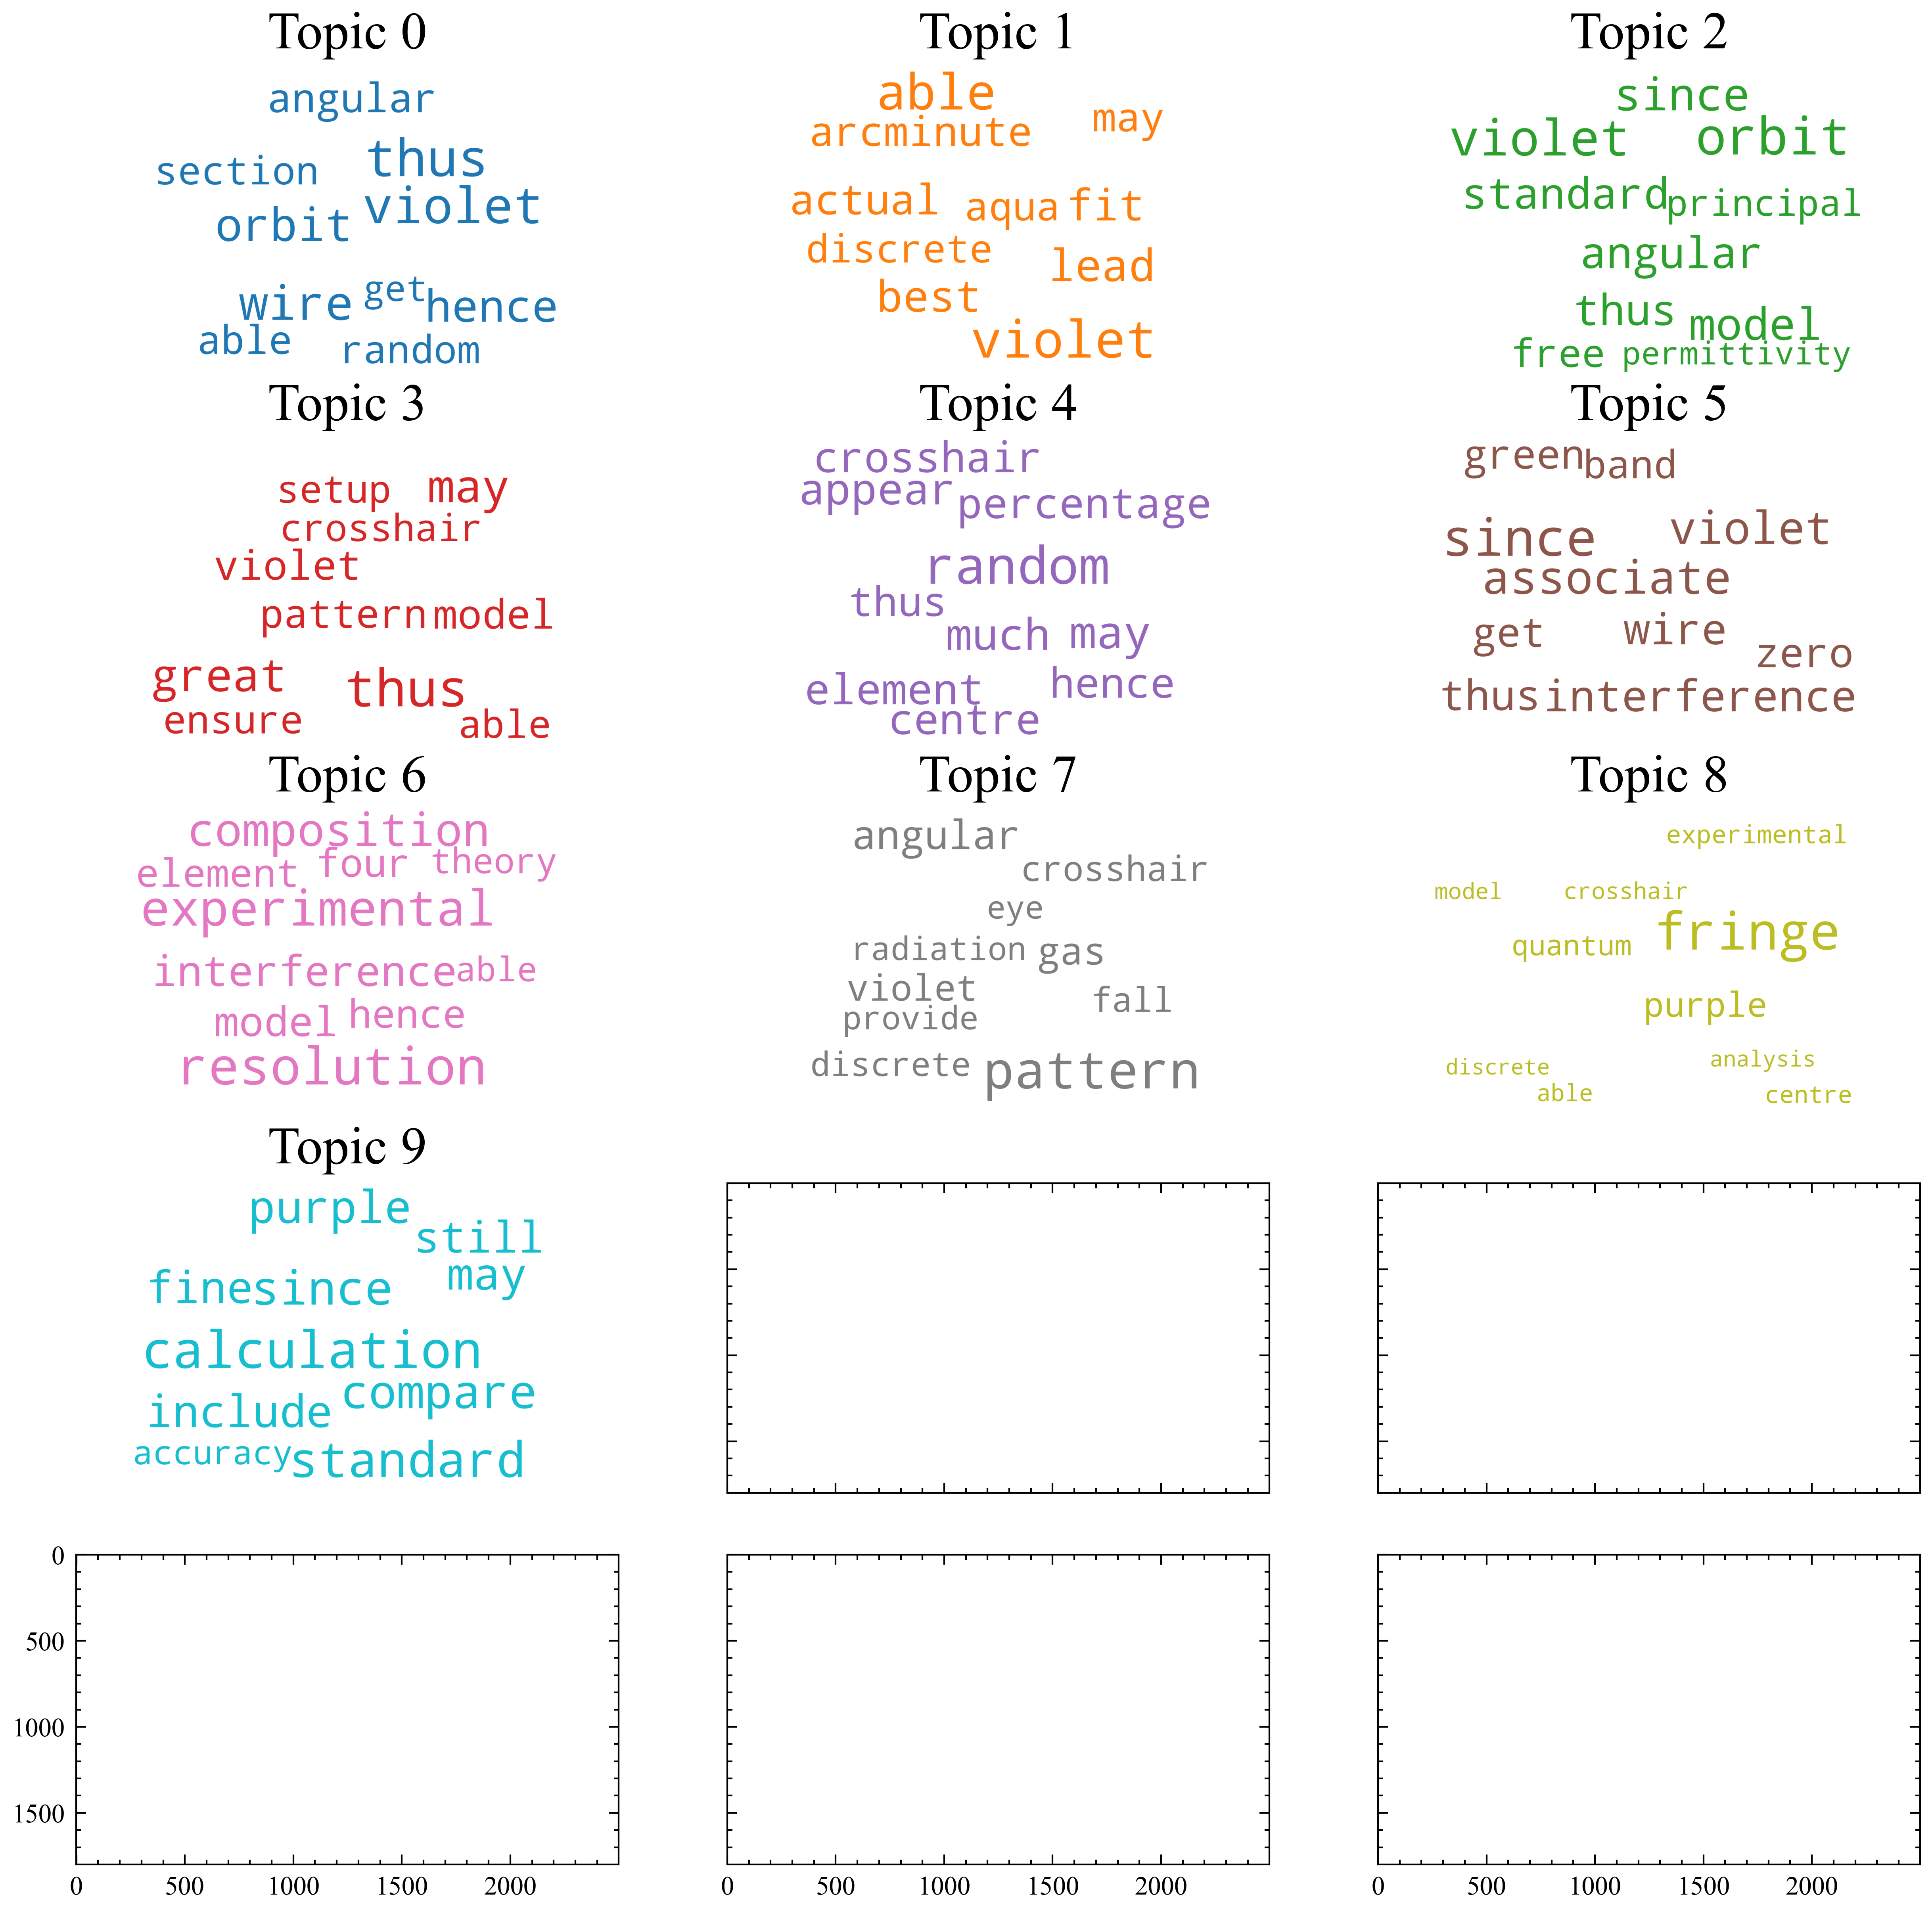

In [54]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda_model_bow.show_topics(formatted=False)

fig, axes = plt.subplots(4, 4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

2.5 Train LDA - TFIDF

In [43]:
lda_model_tfidf = LdaMulticore(corpus_tfidf, num_topics=10, id2word= id2word, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic: 0 Word: 0.002*"orbit" + 0.002*"angular" + 0.001*"standard" + 0.001*"model" + 0.001*"investigation" + 0.001*"bohr" + 0.001*"spectral" + 0.001*"stage" + 0.001*"quantum" + 0.001*"formula"
Topic: 1 Word: 0.002*"theta" + 0.001*"ettor" + 0.001*"𝑚𝑚" + 0.001*"wire" + 0.001*"nucleus" + 0.001*"eqn" + 0.001*"displacement" + 0.001*"orbit" + 0.001*"green" + 0.001*"discrete"
Topic: 2 Word: 0.002*"slope" + 0.001*"fig" + 0.001*"shell" + 0.001*"vemier" + 0.001*"latter" + 0.001*"inverse" + 0.001*"ray" + 0.001*"intercept" + 0.001*"run" + 0.001*"create"
Topic: 3 Word: 0.002*"violet" + 0.001*"turquoise" + 0.001*"strip" + 0.001*"spectral" + 0.001*"figure" + 0.001*"continuous" + 0.001*"pattern" + 0.001*"fig" + 0.001*"percentage" + 0.001*"lead"
Topic: 4 Word: 0.002*"compound" + 0.001*"candle" + 0.001*"licl" + 0.001*"cuso" + 0.001*"burn" + 0.001*"blowtorch" + 0.001*"wax" + 0.001*"errorbars" + 0.001*"january" + 0.001*"orders"
Topic: 5 Word: 0.004*"fringe" + 0.002*"purple" + 0.002*"aqua" + 0.002*"green" +

2.6 Word cloud of trained LDA - TFIDF

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


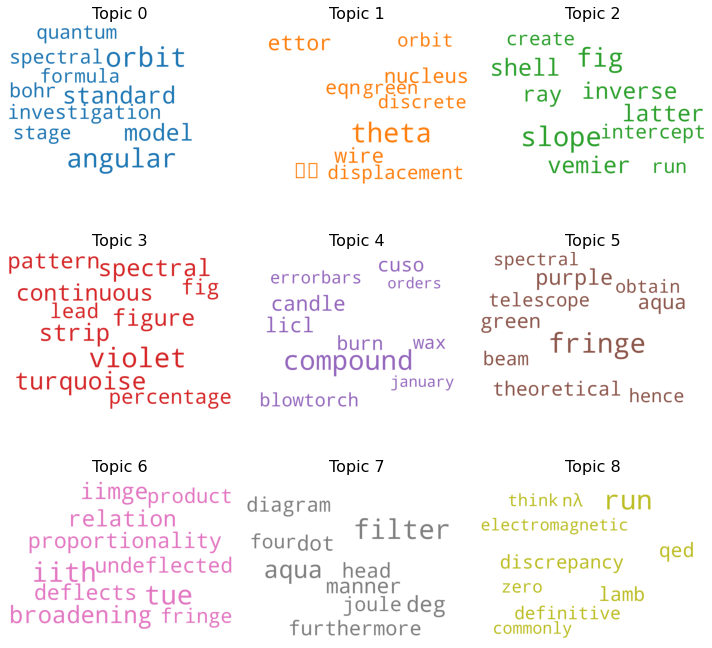

In [50]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda_model_tfidf.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
%pip install pyLDAvis==2.1.2
import pickle 
import pyLDAvis
from pyLDAvis import gensim
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(dir_name_e+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, dir_name_e + str(num_topics) +'.html')
LDAvis_prepared

3 PERFORMANCE ON TEST DOCUMENTS 

3.1 Hand pick test document in train set; BOW- not unseen

In [48]:
for index, score in sorted(lda_model[bow_corpus[94]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic {}: {}".format(score, index, lda_model.print_topic(index, 10)))


Score: 0.5687239170074463	 
Topic1: 0.023*"wavelength" + 0.020*"value" + 0.019*"line" + 0.017*"light" + 0.015*"constant" + 0.014*"rydberg" + 0.014*"error" + 0.012*"calculate" + 0.012*"grate" + 0.010*"order"

Score: 0.3415408432483673	 
Topic3: 0.020*"line" + 0.019*"value" + 0.017*"light" + 0.016*"wavelength" + 0.016*"error" + 0.016*"constant" + 0.015*"grate" + 0.014*"rydberg" + 0.013*"hydrogen" + 0.011*"energy"

Score: 0.043373603373765945	 
Topic7: 0.021*"line" + 0.020*"value" + 0.020*"wavelength" + 0.018*"error" + 0.017*"constant" + 0.016*"light" + 0.016*"energy" + 0.015*"rydberg" + 0.013*"grate" + 0.011*"angle"

Score: 0.03248290345072746	 
Topic5: 0.020*"value" + 0.020*"constant" + 0.019*"rydberg" + 0.018*"error" + 0.018*"wavelength" + 0.016*"light" + 0.016*"line" + 0.015*"grate" + 0.012*"energy" + 0.010*"hydrogen"

Score: 0.010761324316263199	 
Topic8: 0.022*"light" + 0.021*"value" + 0.017*"line" + 0.017*"grate" + 0.016*"error" + 0.015*"hydrogen" + 0.015*"wavelength" + 0.014*"ene

c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
#performance evaluation by classifying sample document using LDA TF-IDF model
for index, score in sorted(lda_model_tfidf[bow_corpus[94]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic {}: {}".format(score, index, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8901399970054626	 
Topic 5: 0.004*"fringe" + 0.002*"purple" + 0.002*"aqua" + 0.002*"green" + 0.002*"theoretical" + 0.002*"beam" + 0.002*"telescope" + 0.002*"hence" + 0.001*"obtain" + 0.001*"spectral"

Score: 0.10922081768512726	 
Topic 0: 0.002*"orbit" + 0.002*"angular" + 0.001*"standard" + 0.001*"model" + 0.001*"investigation" + 0.001*"bohr" + 0.001*"spectral" + 0.001*"stage" + 0.001*"quantum" + 0.001*"formula"


c:\Users\EfiaA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Our test document has the highest probability to be part of the topic
# that our model assigned, which is the accurate classification

LDA on UNSEEN DOCUMENT - FRAME WORK CODE

Reference code: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24#:~:text=Latent%20Dirichlet%20Allocation%20(LDA)%20is,and%20split%20them%20into%20topics.

In [ ]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = id2word.doc2bow(unseen_document)
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))